In [1]:
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import matplotlib.cm as cm

In [2]:
basePath = '../sims.TNG/TNG300-1/output/'
SnapNum = 99

In [3]:
threshold_mass = 10**14.5 # Minimum masses of the halos to select

In [4]:
header = il.groupcat.loadHeader(basePath, 99)
header

{'BoxSize': 205000.0,
 'FlagDoubleprecision': 0,
 'Git_commit': b'd203ec8b07c7e2bdda5f608aa0babea46d603699',
 'Git_date': b'Thu Apr 7 14:14:27 2016 +0200',
 'HubbleParam': 0.6774,
 'Ngroups_ThisFile': 1,
 'Ngroups_Total': 17625892,
 'Nids_ThisFile': 20541399,
 'Nids_Total': 12766437906,
 'Nsubgroups_ThisFile': 11748,
 'Nsubgroups_Total': 14485709,
 'NumFiles': 600,
 'Omega0': 0.3089,
 'OmegaLambda': 0.6911,
 'Redshift': 2.220446049250313e-16,
 'Time': 0.9999999999999998}

In [5]:
h = header['HubbleParam']
hub_const = h * 1e2 * 1e3 / (1e6 * 3.09e16) # H = 100*h, where h = 0.6774 km/s/Mpc
hub_const # s^-1 units

2.192233009708738e-18

In [6]:
omega_0 = header['Omega0']
omega_lambda = header['OmegaLambda']

In [7]:
required_snapshots = [99, 33, 25, 13, 8] # Corresponding to their respective redshifts
tot_snaps = len(required_snapshots)
tot_snaps

5

In [8]:
redshifts = []
times = []
for i in range(tot_snaps):
    header = il.groupcat.loadHeader(basePath, required_snapshots[i])
    redshifts.append(int(header['Redshift']))
    times.append(int(header['Time']))

In [9]:
# Defining a function for unit conversion
def UnitConversion(array, SnapNum, unit):
    header = il.groupcat.loadHeader(basePath, SnapNum)
    h = header['HubbleParam']
    a = header['Time']
    if unit == 'mass':
        array = array * 1e10 / h # In Msun unit
    if unit == 'length':
        array = array * a / (1e3 * h) # In Mpc unit
    return array

In [10]:
fields=['Group_M_Crit200', 'GroupFirstSub']

In [11]:
halos = il.groupcat.loadHalos(basePath, SnapNum, fields=fields)

In [12]:
halos['Group_M_Crit200']

array([104034.41,  88559.22,  69996.71, ...,      0.  ,      0.  ,
            0.  ], dtype=float32)

In [13]:
halos_mass = UnitConversion(halos['Group_M_Crit200'], SnapNum, 'mass')
halos_mass

array([1.5357900e+15, 1.3073401e+15, 1.0333144e+15, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [14]:
# Selecting the halos above a certain threshold mass
halo_IDs = np.nonzero(halos_mass >= threshold_mass)
# halo_IDs[0]

In [15]:
# Extracting the central subhalos of the selected halos
sub_halos_ID = halos['GroupFirstSub'][halo_IDs]
n = len(sub_halos_ID)
# sub_halos_ID

In [16]:
fields = ['Group_M_Crit200','SnapNum', 'FirstSubhaloInFOFGroupID']

In [17]:
trees = [{} for _ in range(n)]

In [18]:
# Loading the merger trees of different subhalos using the Sublink algorithm
for i in range(n):
    trees[i] = il.sublink.loadTree(basePath, SnapNum, sub_halos_ID[i], fields=fields, onlyMPB=True)

/tmp/ipykernel_357/3669527090.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


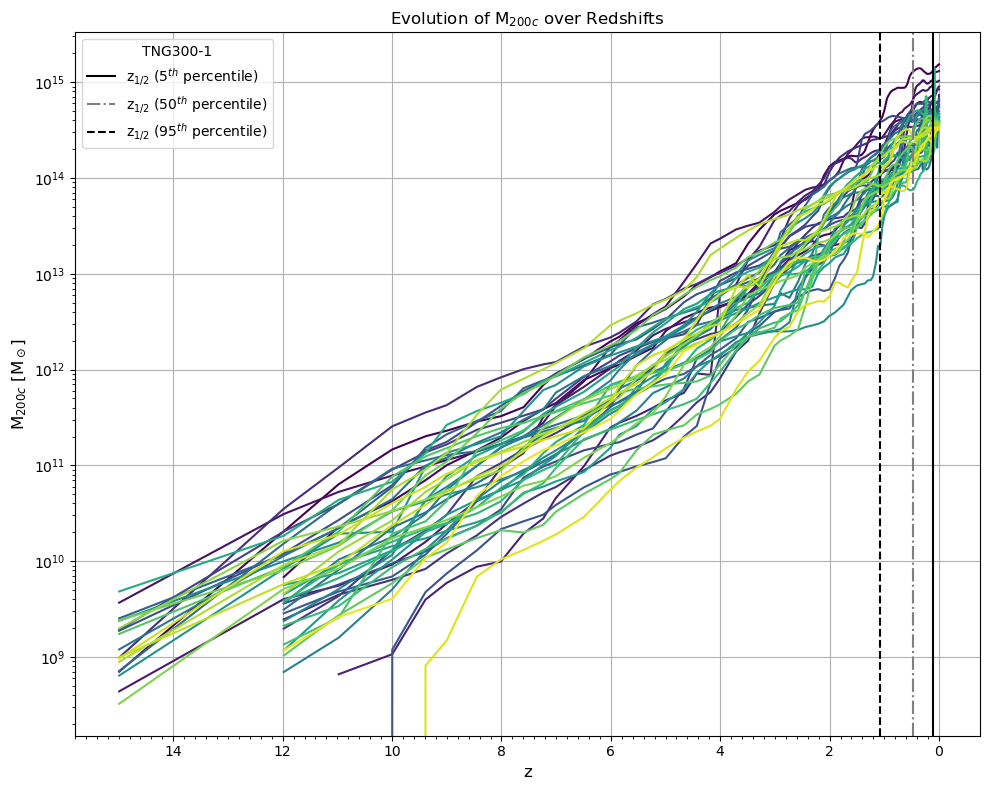

In [26]:
# Plotting the critical masses as a function of redshifts
half_mass = []
fig, ax = plt.subplots(figsize=(10,8))

cmap = cm.get_cmap('viridis')
norm = plt.Normalize(0, n)

for i in range(n):
    tree_mass = []
    redshifts_in_tree = []
    for j in range(len(trees[i]['Group_M_Crit200'])):
        tree_mass.append(UnitConversion(trees[i]['Group_M_Crit200'][j], trees[i]['SnapNum'][j], 'mass'))
        header = il.groupcat.loadHeader(basePath, trees[i]['SnapNum'][j])
        redshifts_in_tree.append(float(header['Redshift']))
    req_indices = np.nonzero(tree_mass < (tree_mass[0]/2))
    ax.plot(redshifts_in_tree, tree_mass, c=cmap(norm(i)))
    # ax.axvline(redshifts_in_tree[req_indices[0][0]])
    half_mass.append(redshifts_in_tree[req_indices[0][0]])
ax.axvline(np.percentile(half_mass, 5), c='k', ls='solid', label='z$_{1/2}$ (5$^{th}$ percentile)')
ax.axvline(np.median(half_mass), c='gray', ls='dashdot', label='z$_{1/2}$ (50$^{th}$ percentile)')
ax.axvline(np.percentile(half_mass, 95), c='k', ls='dashed', label='z$_{1/2}$ (95$^{th}$ percentile)')
# ax.axvline(np.mean(half_mass), c='k', ls='--')
ax.invert_xaxis()
ax.set_yscale('log')
ax.set_xlabel('z', fontsize='large')
ax.set_ylabel('M$_{200c}$ [M$_\odot$]', fontsize='large')
ax.set_title('Evolution of M$_{200c}$ over Redshifts', fontsize='large')
ax.set_xticks(np.arange(0, 16, 0.2), minor=True)
plt.legend(title='TNG300-1', fontsize='medium')
plt.tight_layout()
plt.grid()
plt.savefig('evolution_redshifts_mean_updated.png')
plt.show()

In [20]:
# Define an integrand to find cosmic time
def integrand(a):
    return 1.0 / (a * hub_const * np.sqrt(omega_0 * a**-3 + omega_lambda))

In [21]:
# Integrate from a = 0 to the current scale factor a = 1
cosmic_time, _ = quad(integrand, 0, 1/(1+8))
cosmic_time1, _ = quad(integrand, 0, 1/(1+0))

# Convert time from seconds to years
cosmic_time_years1 = cosmic_time / (3.154e16)
cosmic2 = cosmic_time1 / (3.154e16)
format(cosmic2 - cosmic_time_years1 , '.3g')

'13.2'

/tmp/ipykernel_357/668604969.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


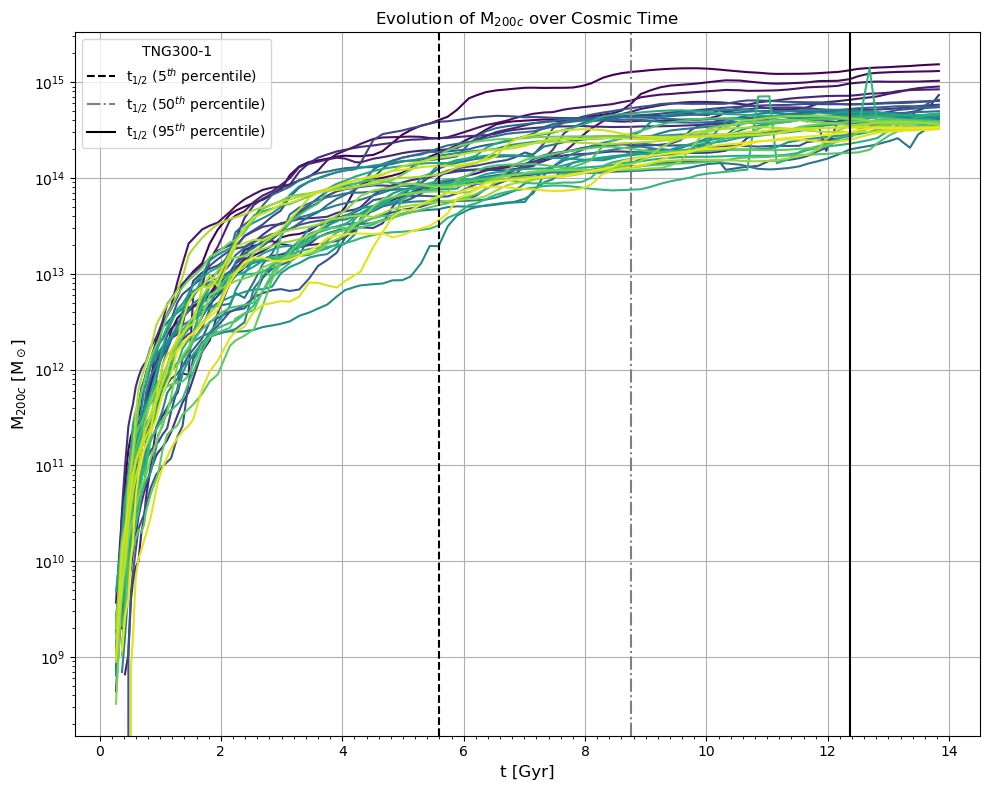

In [22]:
# Plotting the critical masses as a function of snapshots
half_mass = []
fig, ax = plt.subplots(figsize=(10,8))

cmap = cm.get_cmap('viridis')
norm = plt.Normalize(0, n)

for i in range(n):
    tree_mass = []
    time_in_tree = []
    for j in range(len(trees[i]['Group_M_Crit200'])):
        tree_mass.append(UnitConversion(trees[i]['Group_M_Crit200'][j], trees[i]['SnapNum'][j], 'mass'))
        header = il.groupcat.loadHeader(basePath, trees[i]['SnapNum'][j])
        cosmic_time, _ = quad(integrand, 0, header['Time'])
        time_in_tree.append(cosmic_time/3.154e16)
    # if i == 27:
    #     print(np.array(tree_mass))
    ax.plot(time_in_tree, tree_mass, c=cmap(norm(i)))
    req_indices = np.nonzero(tree_mass < (tree_mass[0]/2))
    half_mass.append(time_in_tree[req_indices[0][0]])
    
ax.axvline(np.percentile(half_mass, 5), c='k', ls='dashed', label='t$_{1/2}$ (5$^{th}$ percentile)')
ax.axvline(np.median(half_mass), c='gray', ls='dashdot', label='t$_{1/2}$ (50$^{th}$ percentile)')
ax.axvline(np.percentile(half_mass, 95), c='k', ls='solid', label='t$_{1/2}$ (95$^{th}$ percentile)')
# ax.axvline(np.median(half_mass), c='k', ls='--', label='t$_{1/2}$')
    
ax.set_yscale('log')
ax.set_xlabel('t [Gyr]', fontsize='large')
ax.set_ylabel('M$_{200c}$ [M$_\odot$]', fontsize='large')
ax.set_title('Evolution of M$_{200c}$ over Cosmic Time', fontsize='large')
ax.set_xticks(np.arange(0, 14, 0.2), minor=True)
plt.legend(title='TNG300-1', fontsize='medium')
plt.tight_layout()
plt.grid()
# plt.savefig('evolution_cosmic_time_mean_updated.png')
plt.show()

The dotted lines give a time duration during which the halo masses were half the current values.

Comments:$\newline$
-> The ranking of the most massive halos is not consistent across redshifts.$\newline$
-> There are some halos with order changes that might be of interest.$\newline$
-> HaloID = 43 was the most massive halo at z = 6, but currently (z = 0) it is the 36th most massive halo.$\newline$
-> HaloID = 4 was the least massive halo (among this list) at z = 8, but currently it is the 5th most massive halo.$\newline$
-> HaloID = 1 has shown varying rank across redshifts.$\newline$
-> The above are just a few observations of the order deduced, more inferences can be observed on careful observation of the order and also by increasing the redshifts being considered.